<a href="https://colab.research.google.com/github/unclepeddy/deeplearning/blob/master/3-housing-prices/simple_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
! pip install tf-nightly-2.0-preview

In [2]:
import tensorflow as tf

from tensorflow.keras import models, layers
from tensorflow.keras.datasets import boston_housing

import matplotlib.pyplot as plt
import numpy as np

print(tf.__version__)

2.0.0-dev20190330


In [0]:
# Import Boston housing house price data set
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

# Training hyperparameters
num_validation_folds = 4
num_epochs = 100
is_verbose = 0

# Do feature-wise normalization
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data -= mean
train_data /= std
test_data -= mean
test_data /= std

In [0]:
# Function to build a simple 2 layer model 
def build_model():
  model = models.Sequential()
  model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(1))
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  return model

In [9]:
# Calculate number of examples per validation fold 
fold_size = len(train_data) // num_validation_folds
all_scores = []
all_mae_histories = []

# Train using k-fold validation technique
for i in range(num_validation_folds):
  print("processing fold #", i)
  
  # Select validation set
  val_data = train_data[i * fold_size: (i+1) * fold_size]
  val_targets = train_targets[i * fold_size: (i+1) * fold_size]
  
  # Select training set using the rest of the data
  partial_training_data = np.concatenate(
      [train_data[:i * fold_size], 
      train_data[(i+1) * fold_size:]], axis=0)
  partial_training_targets = np.concatenate(
      [train_targets[:i * fold_size], 
      train_targets[(i+1) * fold_size:]], axis=0)
  
  # Re-compile model and train
  model = build_model()
  history = model.fit(partial_training_data, 
                      partial_training_targets, 
                      validation_data=(val_data, val_targets),
                      epochs=num_epochs, 
                      batch_size=1, 
                      verbose=is_verbose)
  
  # Capture absolute error metric across this run
  mae_history = history.history['val_mae']
  all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


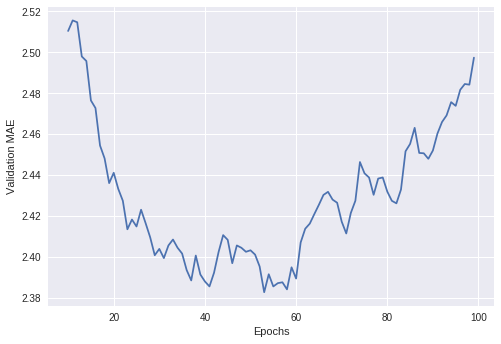

In [10]:
# Calculate average MAE for each epoch
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

# Cut out first 10 epochs and implement explonential moving average
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1] 
      smoothed_points.append(previous * factor + point * (1-factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smoothed_mae_history = smooth_curve(average_mae_history[10:])

# Plot the MAE over epochs after 10
plt.plot(range(10, len(smoothed_mae_history) + 10), smoothed_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [12]:
loss, mae = model.evaluate(test_data, test_targets)

print("Mean Absolute Error: $", mae * 1000)

102/102 [==============================] - 0s 962us/sample - loss: 20.5090 - mae: 2.7885
Mean Absolute Error: $ 2788.5377407073975
